## 1 PID Concept

## 1.1 Exercise 1
Here are some questions about the PID-controller. Use your own words.

> (a) Why a pure P-controller will generate stationary error/offset when used for
most of the existing systems?

A P-controller applies output proportional to the error. For many systems this will reach a equlibrium near the setpoint, but never reaching it. As Kp gain is higher one can get closer, but at risk of overshoot or instability.

> (b) Why the addition of the integral term may remove the stationary error in most
of the cases?

A stationary error will, if not removed, cause the integral of the error to grow over time.
With an I-controller high integral values causes it to take action to counteract, which elimitates the stationary error. 

> (c) Which controller is the fastest and what controller is the slowest among the
pure P-controller, I-controller and D-controller? What does this mean for
systems with high-frequency motion and systems with low frequency motion?

P is faster than I, as I requires values to build up over time. D is theoretically faster than P, as its value suggests potential future values of the system. 

When a fast system is needed and a bit of stationary error is acceptable and measurement/process noise is low, a PD controller can be used. If a system does is OK with slow response time, one can use a PI regulator. Not using a D-term can make the system more stable in presence of noise.

> (d) What is the main motivation for introducing the D-gain in the controller? Can
you suggest another way to achieve the same effect you described?

The D-gain is used to counteract oscillations around the setpoint. As a system with inertia or time-delay has been set into motion towards a setpoint, the amount of should be reduced before one gets to the setpoint - or overshoot will happen. The P term does not do this fast enough.

> (e) Sum up the main effects of each term P, I and D individually on: (i) response
time; (ii) stationary error/offset; (iii) overshoot; (iv) noise; (v) stability

Template for the comparative table
```
P I D

Response time.  Decreases. Decreases. Faster settle time 
Error offset. Decreases. Eliminates. No effect
Overshoot.  Increases. Increases. Decreases
Noise.   Minor. Minor. Increases.
Stability. Decreases. Decreases. Sometimes improves 
```

## 1.2 Exercise 2

In MATLAB/Simulink, create a PID controller for the system plant
$G(s) = \frac{Y(s)}{X(s)} = \frac{s+1}{s^2−5s+6}$
to track its output y(t) to x(t) = 1. Find a suitable tuning for that.

Plot cases for pure P-controller, PI-controller, and PID-controller.
Discuss about the differences.

In [2]:
%matplotlib inline
import numpy
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import pandas

Transfer function of PID regulator $$\frac{Kd s^2 + Kp s + Ki}{s}$$

TransferFunctionContinuous(
array([  1., 102., 102.,   1.]),
array([   1.,   97., -402.,  113.,  557.,   66.]),
dt: None
)


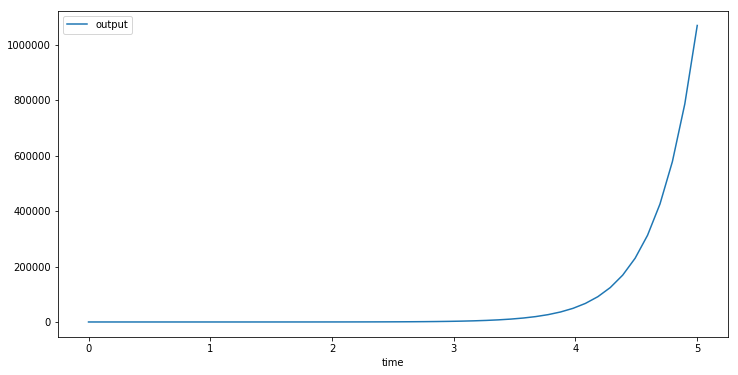

In [25]:
def plant_system():
    num, den = (1, 1), (1, -5, 6)
    return scipy.signal.TransferFunction(num, den)
# looks like system is fundamentally unstable, tends to infinity as t->

def pid(Kp, Ki, Kd):
    num, den = (Kd, Kp, Ki), (1, 0)
    return scipy.signal.TransferFunction(num, den)  

def series(A, B):
    P = numpy.polynomial.Polynomial
    num = P(A.num) * P(B.num)
    den = P(A.den) * P(B.den)
    return scipy.signal.TransferFunction(num.coef, den.coef)
    
def feedback(forward, backward=None, sign=-1):
    if backward is None:
        backward = scipy.signal.TransferFunction((1), (1))

    num1, den1 = forward.num, forward.den
    num2, den2 = forward.den, backward.den
    polymul = numpy.polymul
    polyadd = numpy.polyadd
    
    num = polymul(num1, den2)
    den = polyadd(polymul(den2, den1), -sign * polymul(num2, num1))
    return scipy.signal.TransferFunction(num, den)   

times = numpy.linspace(0, 5.0)
initial = 0.0
G = plant_system()
C = pid(10.1, 0.1, 0.1)
system = feedback(series(C, G))
_,YY = scipy.signal.step(system, initial, T=times)

print(system)

df = pandas.DataFrame({'time': times, 'output': YY})
df.plot(x='time', figsize=(12,6))

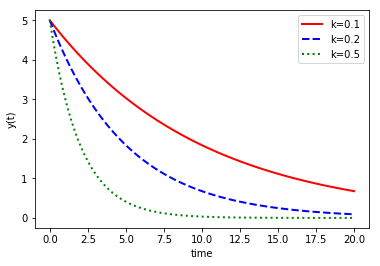

In [5]:
# Initially based on https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/45560737/python-how-to-solve-an-ordinary-differential-equation-with-integral-term-in-it
def pid_orig(t, Y):
    x1, x2, x3 = Y
    e=x1-1
    x1dot = x2
    edot = x1dot
    x3dot = e
    u=kp*e+kd*edot+ki*x3
    x2dot=u-5*x1-2*x2
    return [x1dot, x2dot, x3dot]

# function that returns dy/dt
def model(y,t,k):
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20,100)

# solve ODEs
k = 0.1
y1 = odeint(model,y0,t,args=(k,))
k = 0.2
y2 = odeint(model,y0,t,args=(k,))
k = 0.5
y3 = odeint(model,y0,t,args=(k,))

# plot results
plt.plot(t,y1,'r-',linewidth=2,label='k=0.1')
plt.plot(t,y2,'b--',linewidth=2,label='k=0.2')
plt.plot(t,y3,'g:',linewidth=2,label='k=0.5')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

# 2 Implementation on AUV
Now, let us use the controller for the AUV discussed in the List 1.

## 2.1

(a) Use the dynamic equations that we found in Exercise 1. Assume that our goal
is to make the AUV move with constant velocity v d . Find the expression for
a control signal u(t) by using a P-controller. Find the dynamic equations in
closed loop.

(b) Find the new gain, stationary value and transient in closed loop with the P-
controller as a function of K p . What is the effect of increasing K p ? Point out
the positive and negative effects of augmenting the gain K p .

(c) Find the dynamics of the AUV in closed loop with a PID-controller. Write
the system as a first order differential equation in matrix form.

(d) Draw the block diagram for the system with PID controller.

(e) Assume, as in Exercise 1, that m = 200kg and k = 100kg/s . Implement the
block diagram in MATLAB/Simulink. Find values for K p , K i , K d that give
us fast response with little oscillations. Remember to choose feasible/realistic
values in the real world, for example K p < 5 and not K p > 10000000 (which
would demand a gigantic energy cost).

(f) Set K d = 0 . Tune K p and K i so that the system becomes critically damped .

(g) Find the dynamic equations for the system with the PI-controller. Based on it,
calculate values for K p and K i so that the system becomes critically damped .
Do the values correspond with the values that you found by tuning in the
previous item (f)?

# 3. Digital PID

## 3.1 Exercise 4
(a) What is the difference between the Backward Euler, Forward Euler and Tustin
method for implementing the integral or derivative part?

(b) Write an equation for the PID-controller in digital domain, where the Back-
ward Euler method is used. Use the time period T .

(c) What is the effect of a high time period in the system stability?

(d) Draw a block diagram for the digital PID controller. Include the block of A/D
and D/A converter.